In [1]:
%config Completer.use_jedi = False



import warnings
warnings.filterwarnings('ignore')
import neptune
import pandas as pd
import pathlib
import PIL
from fastai.callbacks import *
from fastai.vision import * 
from fastai.metrics import *
import neptune
import neptunecontrib
import sys

import neptune

from fastai.basic_train import LearnerCallback
from neptunecontrib.api.utils import get_filepaths



In [2]:
class NeptuneMonitor(LearnerCallback):

    def __init__(self, experiment=None, learn=None, prefix=''):
        self._exp = experiment if experiment else neptune
        self._prefix = prefix
        if learn is not None:
            super().__init__(learn)

    def on_epoch_end(self, **kwargs):
        self._exp.send_metric(self._prefix + 'train_smooth_loss', float(kwargs['smooth_loss']))
        metric_values = kwargs['last_metrics']
        metric_names = ['valid_last_loss'] + kwargs['metrics']
        for metric_value, metric_name in zip(metric_values, metric_names):
            metric_name = getattr(metric_name, '__name__', metric_name)
            self._exp.send_metric(self._prefix + str(metric_name), float(metric_value))

    def on_batch_end(self, last_loss, iteration, train, **kwars)->None:
        "Callback function that writes batch end appropriate data to Tensorboard."
        if iteration == 0 or not train:  
            return
        self._exp.send_metric('{}last_loss'.format(self._prefix), last_loss)                     


neptune.init('i008/dsr', api_token=os.environ.get('NEPTUNE_TOKEN'))

Project(i008/dsr)

In [3]:
PATH_TO_SNEAKER_NOT_SNEAKER_DATASET = '/home/i008/small_sneaker_not_sneaker'
base_path = pathlib.Path(PATH_TO_SNEAKER_NOT_SNEAKER_DATASET)

classes = []
paths = []
for p in base_path.glob('*/*'):
    relative_path = p.relative_to(base_path)
    classes.append(str(relative_path.parent))
    paths.append(p)
    
df = pd.DataFrame({"tags": classes, "image_path": paths}).sample(frac=1).reset_index()
df.tags = df.tags.map({'sneaker': 1, 'nontsneaker': 0})
df.head()


corrupted = []
for p in df.image_path:
    try:
        PIL.Image.open(p)
    except:
        corrupted.append(p)
        print(p)

df = df[~df.image_path.isin(corrupted)]


In [5]:
idb=ImageDataBunch.from_df('/', 
                           df=df, 
                           ds_tfms=get_transforms(),
                           size=(256, 256), 
                           label_col='tags', 
                           bs=16, 
                           fn_col='image_path').normalize(imagenet_stats)

idb

ImageDataBunch;

Train: LabelList (1600 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
1,0,1,1,1
Path: /;

Valid: LabelList (400 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
0,0,0,0,0
Path: /;

Test: None

In [31]:
# params = {
   

# }
with neptune.create_experiment(name='sneaker_n_sneaker-resnet18'):
    learn = cnn_learner(idb, 
                        models.densenet201, 
                        metrics=[accuracy],
                        model_dir='./OK', path='.')

    save = SaveModelCallback(learn, every='epoch')
    nep = NeptuneMonitor(learn=learn)
    learn.fit_one_cycle(20, callbacks=[nep, save])


https://ui.neptune.ml/i008/dsr/e/DSR-29


KeyboardInterrupt: 

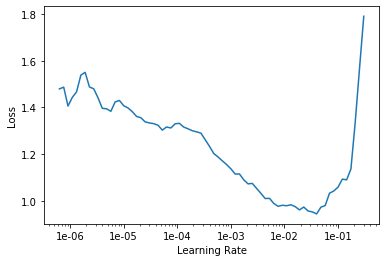

In [27]:
# learn.interpret()

# learn.TTA()

# learn.lr_find()

learn.recorder.plot()

In [38]:
interp = ClassificationInterpretation.from_learner(learn)

In [23]:
# learn.export('ok.pth')

learn.load('bestmodel')

Learner(data=ImageDataBunch;

Train: LabelList (1600 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
1,0,1,1,1
Path: /;

Valid: LabelList (400 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
0,0,0,0,0
Path: /;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        

In [52]:
%config Completer.use_jedi = False


ValueError: 'Completer' is not in list